In [5]:
# importing the necessary libraries
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline
import seaborn as sns

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve

#ML libraries
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

#Misc libraries
import warnings
warnings.filterwarnings("ignore")

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sml-project/fintech_dataset.csv


In [7]:
dataset = pd.read_csv('/kaggle/input/sml-project/fintech_dataset.csv')
dataset = pd.DataFrame(dataset)

In [8]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
dataset.shape

(6362620, 11)

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
# checking for null values
dataset.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Hence, no null values in the dataset

In [12]:
dataset.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

Exploratory data analysis (EDA) - Data Visualizations

In [13]:
# Exploring transaction type
print(dataset["type"].unique())
type = dataset["type"].value_counts()
type

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [14]:
# getting the categories in type column
transaction = type.index
transaction

Index(['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT'], dtype='object', name='type')

In [15]:
# getting the quantity of each category in type column
quantity = type.values
quantity

array([2237500, 2151495, 1399284,  532909,   41432])

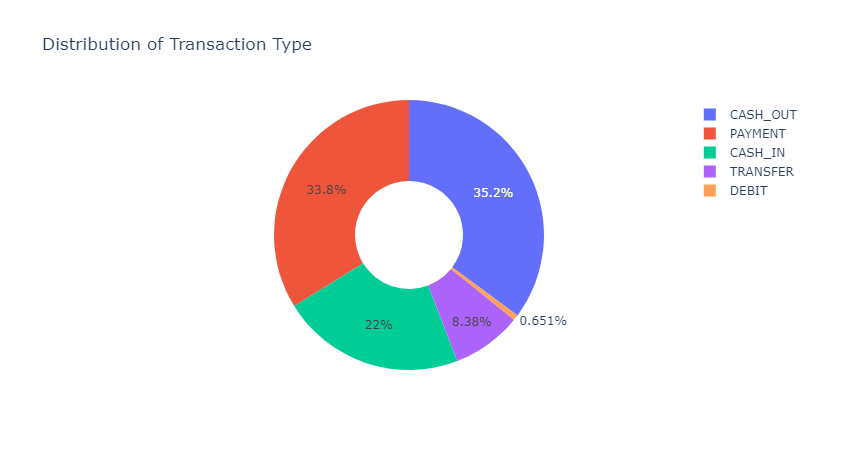

In [16]:
# Visualizing the type column categories
px.pie(dataset, values = quantity, names = transaction,hole = 0.4,title = "Distribution of Transaction Type")

In [17]:
fraud_counts = dataset['isFraud'].value_counts()
fraud_counts

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [18]:
# Calculate the percentage of fraud and non-fraud cases
fraud_percentage = (fraud_counts[1] / len(dataset)) * 100
non_fraud_percentage = (fraud_counts[0] / len(dataset)) * 100

# Print the fraud and non-fraud percentages
print("Fraud percentage:", fraud_percentage)
print("Non-fraud percentage:", non_fraud_percentage)

Fraud percentage: 0.12908204481801522
Non-fraud percentage: 99.87091795518198


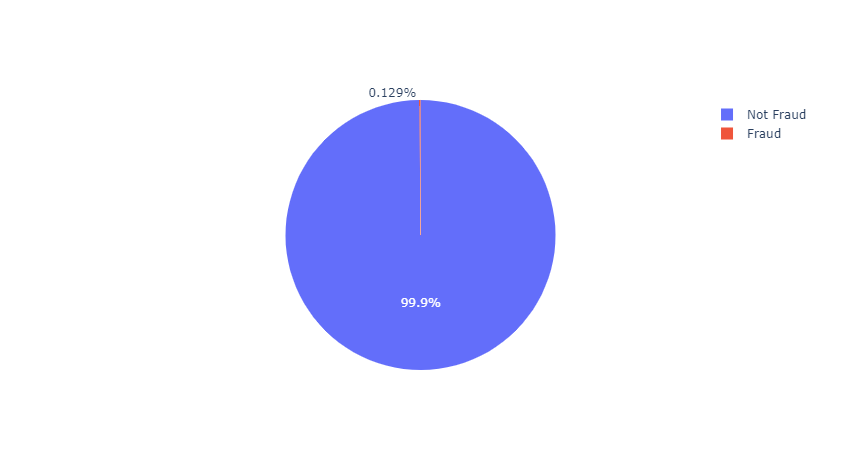

In [19]:
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=dataset['isFraud'].value_counts())])
fig.show()

In [20]:
print('\n The types of fraudulent transactions are {}'.format(\
list(dataset.loc[dataset.isFraud == 1].type.drop_duplicates().values)))

datasetFraudTransfer = dataset.loc[(dataset.isFraud == 1) & (dataset.type == 'TRANSFER')]
datasetFraudCashout = dataset.loc[(dataset.isFraud == 1) & (dataset.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(datasetFraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(datasetFraudCashout)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


<Axes: xlabel='type', ylabel='count'>

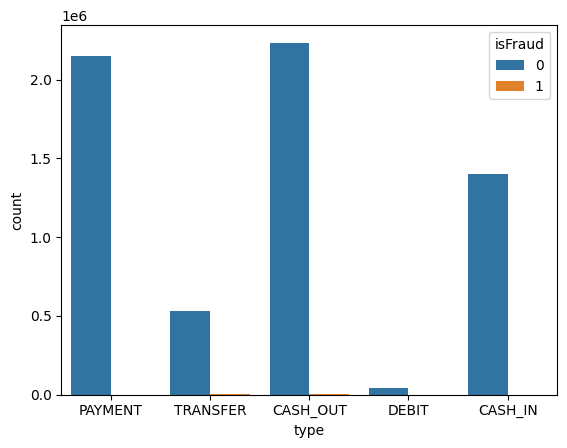

In [21]:
sns.countplot(x = 'type', hue = 'isFraud', data = dataset)

Which types of transactions are fraudulent? <br>
We find that out of the five types of transactions, fraud occurs only in two of them : 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs.fraud is committed by first transferring out funds to another account which subsequently cashes it out.

In [22]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(dataset.loc[dataset.isFlaggedFraud == 1].type.drop_duplicates()))) 

datasetTransfer = dataset.loc[dataset.type == 'TRANSFER']
datasetFlagged = dataset.loc[dataset.isFlaggedFraud == 1]
datasetFlaggedFraud = dataset.loc[(dataset.isFraud == 1) & (dataset.isFlaggedFraud == 1)]
datasetNotFlagged = dataset.loc[dataset.isFlaggedFraud == 0]

print ('\nThe number of flagged TRANSFERs = {}'.\
       format(len(datasetFlagged)))
print ('\nThe number of flagged & fraudulent TRANSFERs = {}'.\
       format(len(datasetFlaggedFraud)))


# print('\nMin amount transacted when isFlaggedFraud is set= {}'\
#                                   .format(datasetFlagged.amount.min()))

# print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
#  {}'.format(datasetTransfer.loc[datasetTransfer.isFlaggedFraud == 0].amount.max()))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

The number of flagged TRANSFERs = 16

The number of flagged & fraudulent TRANSFERs = 16


What determines whether the feature isFlaggedFraud gets set or not? <br>
It turns out that the origin of isFlaggedFraud is unclear, contrasting with the description provided. The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.
<br>
Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

In [23]:
print((dataset.loc[dataset.type == 'CASH_IN'].nameOrig.str.contains('M')).any())

False


It was stated that CASH_IN involves being paid by a merchant (whose name is prefixed by 'M'). However, the present data does not have merchants making CASH_IN transactions to customers.

In [24]:
print((dataset.loc[dataset.type == 'CASH_OUT'].nameDest.str.contains('M')).any())

False


Similarly, it was stated that CASH_OUT involves paying a merchant. However, for CASH_OUT transactions there are no merchants among the destination accounts.

**Label Encoding**

In [25]:
from sklearn.preprocessing import LabelEncoder
column_list = ['type', 'nameOrig' , 'nameDest']

encoders = {}

# Loop through each column that needs encoding
for column in column_list:
    # Create a LabelEncoder for the column
    encoder = LabelEncoder()
    # Fit and transform the data using LabelEncoder
    dataset[column] = encoder.fit_transform(dataset[column])
    # Store the encoder in the dictionary for future use (if needed)
    encoders[column] = encoder

# Print the DataFrame with the encoded columns
dataset

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.00,160296.36,1662094,0.00,0.00,0,0
1,1,3,1864.28,2188998,21249.00,19384.72,1733924,0.00,0.00,0,0
2,1,4,181.00,1002156,181.00,0.00,439685,0.00,0.00,1,0
3,1,1,181.00,5828262,181.00,0.00,391696,21182.00,0.00,1,0
4,1,3,11668.14,3445981,41554.00,29885.86,828919,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,5651847,339682.13,0.00,505863,0.00,339682.13,1,0
6362616,743,4,6311409.28,1737278,6311409.28,0.00,260949,0.00,0.00,1,0
6362617,743,1,6311409.28,533958,6311409.28,0.00,108224,68488.84,6379898.11,1,0
6362618,743,4,850002.52,2252932,850002.52,0.00,319713,0.00,0.00,1,0


In [26]:
## Drop the columns that will not be of any use in the process of model training
finance_dataset = dataset.drop(columns = ['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
finance_dataset

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,170136.00,160296.36,0.00,0.00,0
1,3,1864.28,21249.00,19384.72,0.00,0.00,0
2,4,181.00,181.00,0.00,0.00,0.00,1
3,1,181.00,181.00,0.00,21182.00,0.00,1
4,3,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,1,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,4,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,1,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,4,850002.52,850002.52,0.00,0.00,0.00,1


<Axes: >

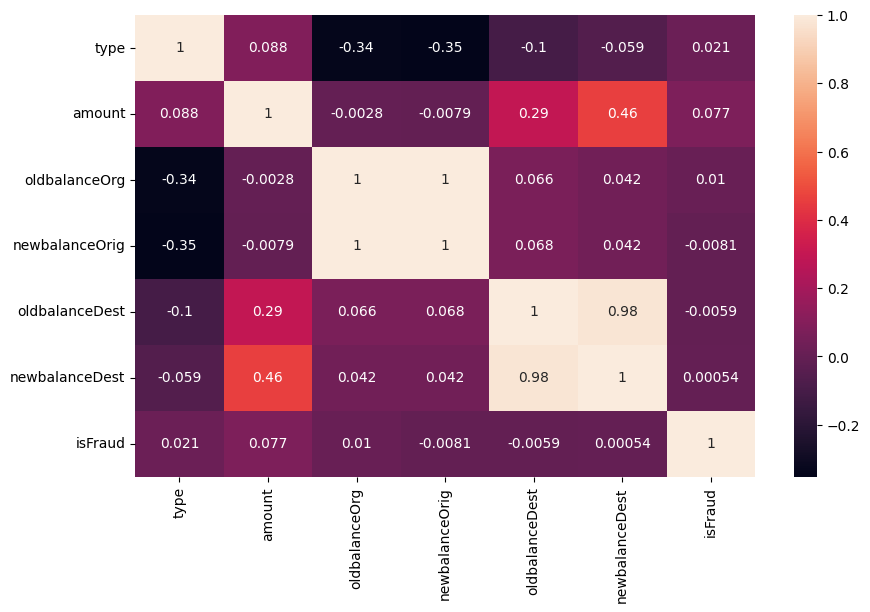

In [27]:
corr = finance_dataset.corr()
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot = True)

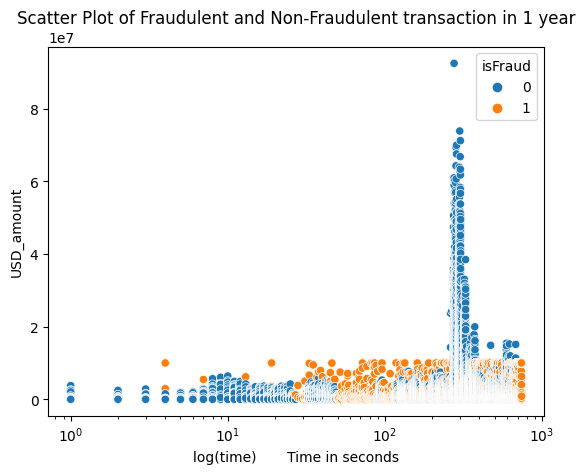

In [28]:
# Define the time range
t_min = 0
t_max = 31_536_000/20  # The upper limit of the range

# Filter the data to only include rows where 'Time_step' is within the specified range
filtered_data = dataset[(dataset['step'] >= t_min) & (dataset['step'] <= t_max)]

# Create a scatter plot using Seaborn with the filtered data
sns.scatterplot(data=filtered_data, x='step', y='amount', hue='isFraud')

# Customize the plot (optional)
plt.title('Scatter Plot of Fraudulent and Non-Fraudulent transaction in 1 year')
plt.xlabel('log(time)       Time in seconds')
plt.ylabel('USD_amount')

plt.xscale('log')
# Display the plot
plt.show()

In [29]:
# Separating the data and the label
X = finance_dataset.drop(columns = ['isFraud'],axis = 1)
Y = finance_dataset['isFraud']

In [30]:
X.shape

(6362620, 6)

In [31]:
Y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

**Train-Test Split**

In [32]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.1, stratify = Y, random_state = 2)

In [33]:
print(X_Train.shape, Y_Train.shape, X_Test.shape, Y_Test.shape)

(5726358, 6) (5726358,) (636262, 6) (636262,)


**Model Training-Testing**

In [34]:
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,roc_curve

Logical Regression

In [35]:
LRmodel = LogisticRegression()
# Training the Logistic Regression Model with Training Data
LRmodel.fit(X_Train, Y_Train)
# accuracy on test data
print('Logistic Regression Model:')
X_test_prediction = np.array(LRmodel.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))


Logistic Regression Model:
[[635377     64]
 [   467    354]]
Accuracy score on Test Data : 0.9991654381371197%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.85      0.43      0.57       821

     accuracy                           1.00    636262
    macro avg       0.92      0.72      0.79    636262
 weighted avg       1.00      1.00      1.00    636262



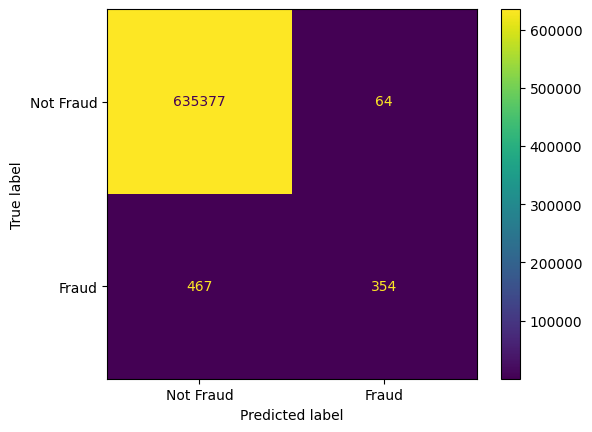

In [36]:
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

K-nearest Classifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier
KNCmodel = KNeighborsClassifier()
KNCmodel.fit(X_Train,Y_Train)
# accuracy on test data
print('KNeighbours Classifier Model:')
X_test_prediction = np.array(KNCmodel.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))


KNeighbours Classifier Model:
[[635358     83]
 [   261    560]]
Accuracy score on Test Data : 0.9994593422206576%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.87      0.68      0.77       821

     accuracy                           1.00    636262
    macro avg       0.94      0.84      0.88    636262
 weighted avg       1.00      1.00      1.00    636262



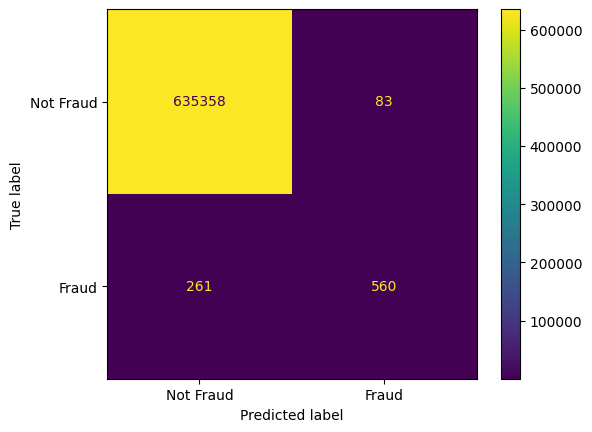

In [38]:
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

XGBoost - Gradient Boosting

In [39]:
import xgboost as xgb
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
xgbr.fit(X_Train, Y_Train)
print('XGBoost Model:')
X_test_prediction = np.array(xgbr.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))

XGBoost Model:
[[635427     14]
 [   245    576]]
Accuracy score on Test Data : 0.9995929349859021%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.98      0.70      0.82       821

     accuracy                           1.00    636262
    macro avg       0.99      0.85      0.91    636262
 weighted avg       1.00      1.00      1.00    636262



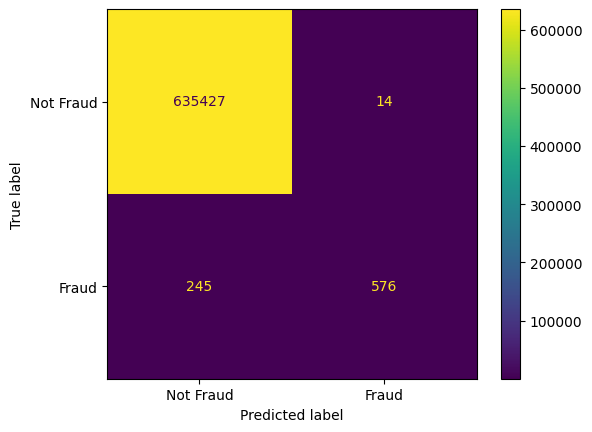

In [40]:
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_Train, Y_Train)
print('Random Forest Model:')
X_test_prediction = np.array(rfc.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))


Random Forest Model:
[[635421     20]
 [   169    652]]
Accuracy score on Test Data : 0.9997029525572798%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.97      0.79      0.87       821

     accuracy                           1.00    636262
    macro avg       0.98      0.90      0.94    636262
 weighted avg       1.00      1.00      1.00    636262



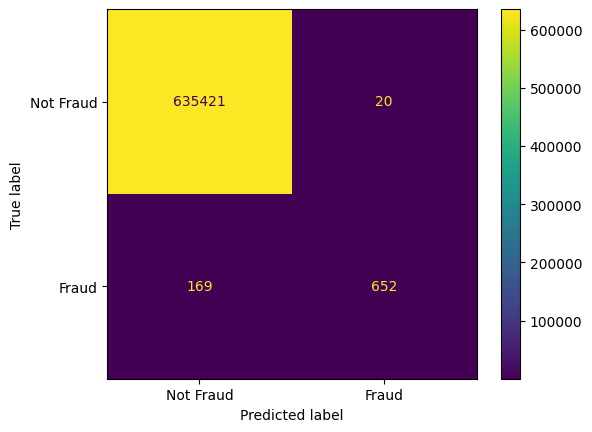

In [42]:
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Decision Tree Classifier

In [43]:
from sklearn.tree import DecisionTreeClassifier
dt_c=DecisionTreeClassifier(random_state=42)
dt_c.fit(X_Train, Y_Train)
print('Decision Tree Classifier Model:')
X_test_prediction = np.array(dt_c.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))

Decision Tree Classifier Model:
[[635373     68]
 [    83    738]]
Accuracy score on Test Data : 0.9997626763817421%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.92      0.90      0.91       821

     accuracy                           1.00    636262
    macro avg       0.96      0.95      0.95    636262
 weighted avg       1.00      1.00      1.00    636262



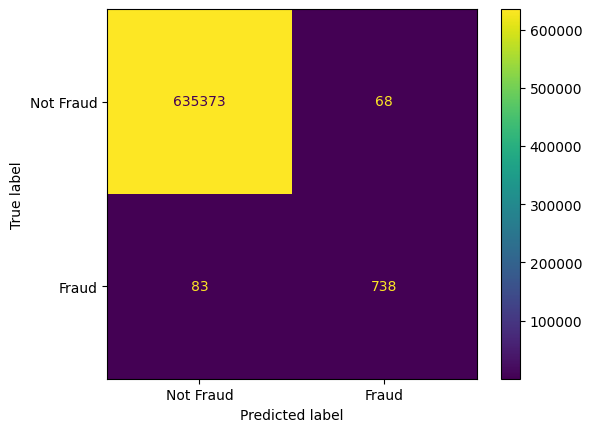

In [44]:
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

AdaBoosting

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
# Create an AdaBoostClassifier instance
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_Train, Y_Train)
print('ADABoost Model:')
X_test_prediction = np.array(adaboost_clf.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))

ADABoost Model:
[[635430     11]
 [   487    334]]
Accuracy score on Test Data : 0.9992173035636263%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.97      0.41      0.57       821

     accuracy                           1.00    636262
    macro avg       0.98      0.70      0.79    636262
 weighted avg       1.00      1.00      1.00    636262



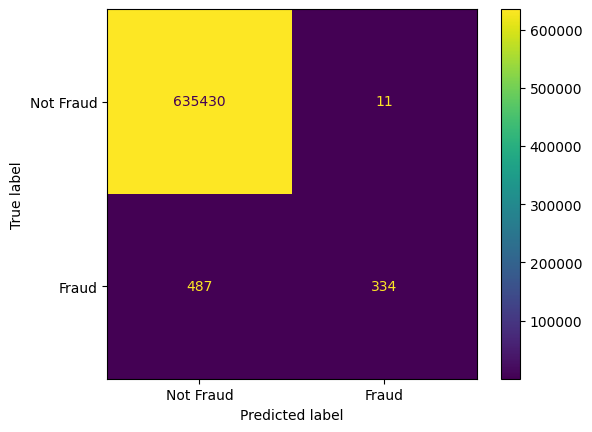

In [46]:
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

**Handling Imbalanced Data**

In [47]:
unique, count = np.unique(Y_Train, return_counts=True)
Y_Train_dict = {k:v for (k,v) in zip(unique, count)}
Y_Train_dict

{0: 5718966, 1: 7392}

In [48]:
# Concatenate X_Train and Y_Train along the columns axis (axis=1)
train_data = pd.concat([X_Train, Y_Train], axis=1)
train_data
# Divide by class
d_class_0 = train_data[train_data['isFraud'] == 0]
d_class_1 = train_data[train_data['isFraud'] == 1]

In [49]:
train_data.isFraud.value_counts()

isFraud
0    5718966
1       7392
Name: count, dtype: int64

In [50]:
# Class count
count_class_0, count_class_1 = train_data.isFraud.value_counts()
print(count_class_0)
print(count_class_1)

5718966
7392


<h3> 1. Undersampling </h3>

In [51]:
# Undersample 0-class and concat the DataFrames of both class
d_class_0_under = d_class_0.sample(count_class_1)
d_test_under = pd.concat([d_class_0_under, d_class_1], axis=0)

print('Random under-sampling:')
print(d_test_under.isFraud.value_counts())

Random under-sampling:
isFraud
0    7392
1    7392
Name: count, dtype: int64


In [52]:
## Separating the data and the label
X_Train_under = d_test_under.drop(columns = ['isFraud'],axis = 1)
Y_Train_under = d_test_under['isFraud']

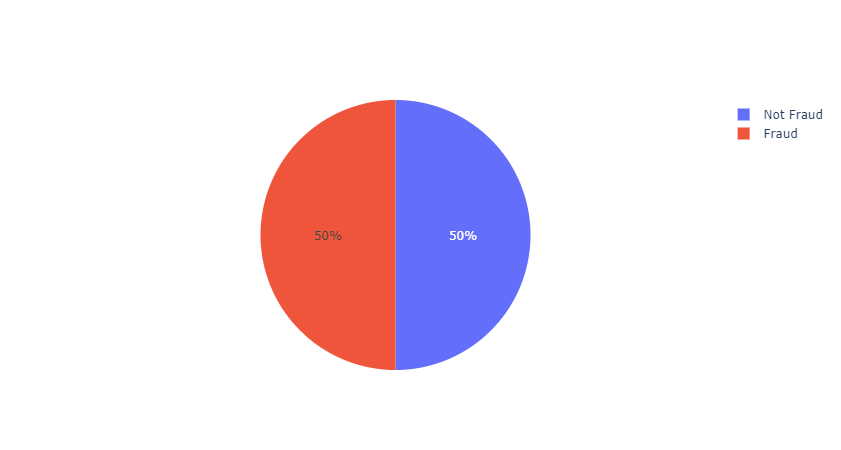

In [53]:
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=d_test_under['isFraud'].value_counts())])
fig.show()

Logistic Regression with Undersampling

Logistic Regression Model:
[[419175 216266]
 [    14    807]]
Accuracy score on Test Data : 0.6600771380343318%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.66      0.79    635441
    Fraud [1]       0.00      0.98      0.01       821

     accuracy                           0.66    636262
    macro avg       0.50      0.82      0.40    636262
 weighted avg       1.00      0.66      0.79    636262



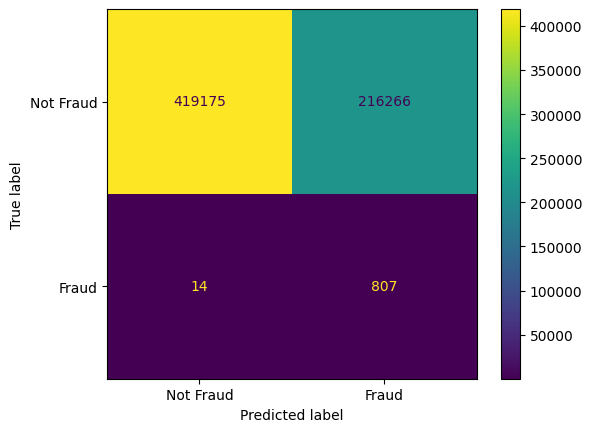

In [54]:
LRmodel = LogisticRegression()
# Training the Logistic Regression Model with Training Data
LRmodel.fit(X_Train_under, Y_Train_under)
# accuracy on test data
print('Logistic Regression Model:')
X_test_prediction = np.array(LRmodel.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

KNeighbors Classifier with Undersampling

KNeighbours Classifier Model:
[[602425  33016]
 [    24    797]]
Accuracy score on Test Data : 0.9480717063096649%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.95      0.97    635441
    Fraud [1]       0.02      0.97      0.05       821

     accuracy                           0.95    636262
    macro avg       0.51      0.96      0.51    636262
 weighted avg       1.00      0.95      0.97    636262



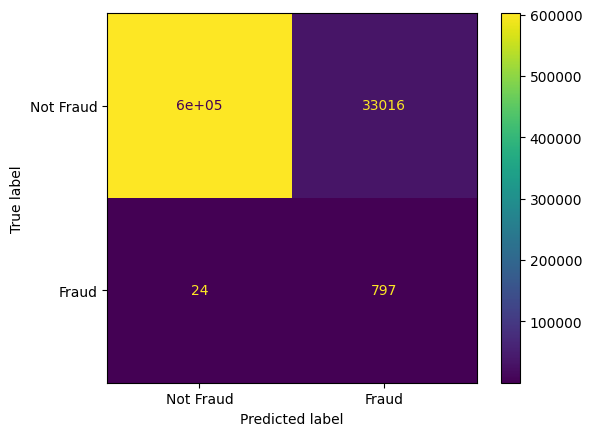

In [55]:
from sklearn.neighbors import KNeighborsClassifier
KNCmodel = KNeighborsClassifier()
KNCmodel.fit(X_Train_under,Y_Train_under)
# accuracy on test data
print('KNeighbours Classifier Model:')
X_test_prediction = np.array(KNCmodel.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

XG Boost model with Undersampling

XGBoost Model:
[[623862  11579]
 [     0    821]]
Accuracy score on Test Data : 0.981801522014516%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.98      0.99    635441
    Fraud [1]       0.07      1.00      0.12       821

     accuracy                           0.98    636262
    macro avg       0.53      0.99      0.56    636262
 weighted avg       1.00      0.98      0.99    636262



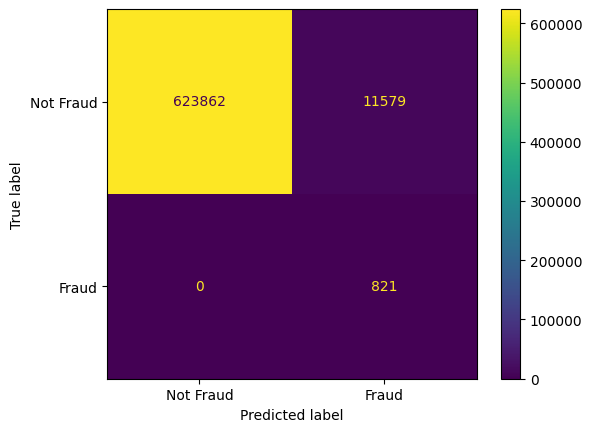

In [56]:
import xgboost as xgb
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
xgbr.fit(X_Train_under, Y_Train_under)
print('XGBoost Model:')
X_test_prediction = np.array(xgbr.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Random Forest Classifier with Undersampling

Random Forest Model:
[[628524   6917]
 [     2    819]]
Accuracy score on Test Data : 0.9891255489090972%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.99      0.99    635441
    Fraud [1]       0.11      1.00      0.19       821

     accuracy                           0.99    636262
    macro avg       0.55      0.99      0.59    636262
 weighted avg       1.00      0.99      0.99    636262



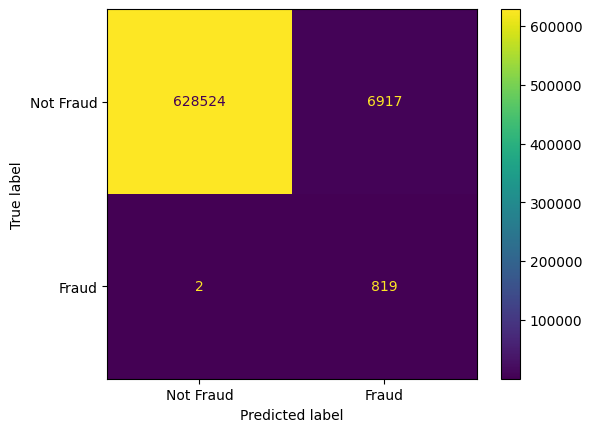

In [57]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_Train_under, Y_Train_under)
print('Random Forest Model:')
X_test_prediction = np.array(rfc.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Decision Tree Classifier with Undersampling

In [58]:
from sklearn.tree import DecisionTreeClassifier
dt_c=DecisionTreeClassifier(random_state=42)
dt_c.fit(X_Train_under, Y_Train_under)
print('Decision Tree Classifier Model:')
X_test_prediction = np.array(dt_c.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))

Decision Tree Classifier Model:
[[629267   6174]
 [     3    818]]
Accuracy score on Test Data : 0.9902917351657021%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.99      1.00    635441
    Fraud [1]       0.12      1.00      0.21       821

     accuracy                           0.99    636262
    macro avg       0.56      0.99      0.60    636262
 weighted avg       1.00      0.99      0.99    636262



<h3> 2. Oversampling </h3>

In [59]:
# Oversample 1-class and concat the DataFrames of both classes
d_class_1_over = d_class_1.sample(count_class_0, replace=True)
d_test_over = pd.concat([d_class_0, d_class_1_over], axis=0)

print('Random over-sampling:')
print(d_test_over.isFraud.value_counts())

Random over-sampling:
isFraud
0    5718966
1    5718966
Name: count, dtype: int64


In [61]:
# Separating the data and the label
X_Train_over = d_test_over.drop(columns = ['isFraud'],axis = 1)
Y_Train_over = d_test_over['isFraud']

KNeighbors Classifier with Oversampling

KNeighbours Classifier Model:
[[634865    576]
 [   152    669]]
Accuracy score on Test Data : 0.9988558172576706%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.54      0.81      0.65       821

     accuracy                           1.00    636262
    macro avg       0.77      0.91      0.82    636262
 weighted avg       1.00      1.00      1.00    636262



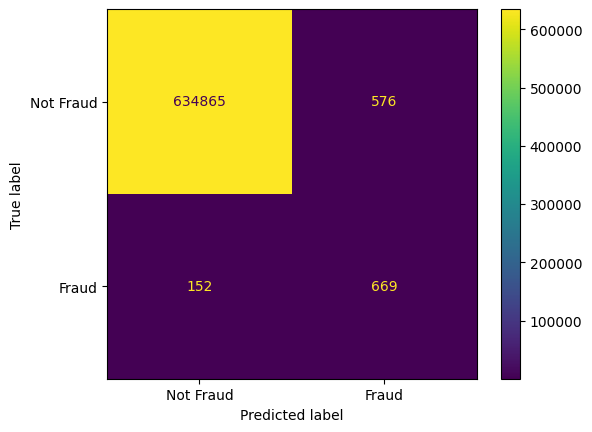

In [62]:
from sklearn.neighbors import KNeighborsClassifier
KNCmodel = KNeighborsClassifier()
KNCmodel.fit(X_Train_over,Y_Train_over)
# accuracy on test data
print('KNeighbours Classifier Model:')
X_test_prediction = np.array(KNCmodel.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

XG Boost with Oversampling

XGBoost Model:
[[623928  11513]
 [     0    821]]
Accuracy score on Test Data : 0.9819052528675294%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.98      0.99    635441
    Fraud [1]       0.07      1.00      0.12       821

     accuracy                           0.98    636262
    macro avg       0.53      0.99      0.56    636262
 weighted avg       1.00      0.98      0.99    636262



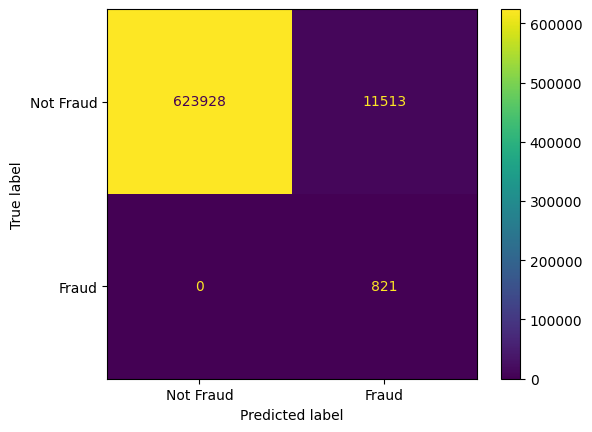

In [63]:
import xgboost as xgb
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
xgbr.fit(X_Train_over, Y_Train_over)
print('XGBoost Model:')
X_test_prediction = np.array(xgbr.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Random Forest Classifier with Oversampling

Random Forest Model:
[[635384     57]
 [   140    681]]
Accuracy score on Test Data : 0.9996903791205509%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.92      0.83      0.87       821

     accuracy                           1.00    636262
    macro avg       0.96      0.91      0.94    636262
 weighted avg       1.00      1.00      1.00    636262



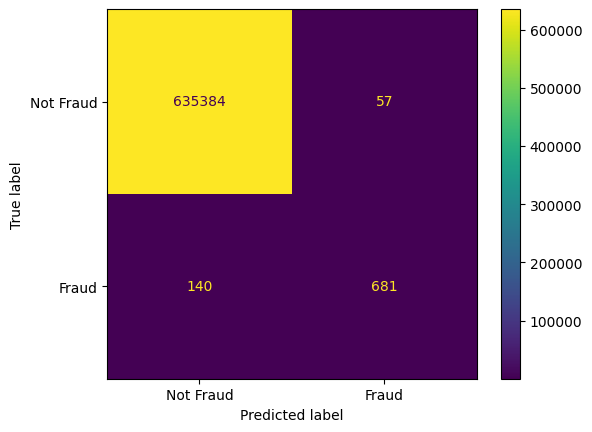

In [65]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_Train_over, Y_Train_over)
print('Random Forest Model:')
X_test_prediction = np.array(rfc.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Decision Tree Classifier with Oversampling

In [66]:
from sklearn.tree import DecisionTreeClassifier
dt_c=DecisionTreeClassifier(random_state=42)
dt_c.fit(X_Train_over, Y_Train_over)
print('Decision Tree Classifier Model:')
X_test_prediction = np.array(dt_c.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))

Decision Tree Classifier Model:
[[635376     65]
 [   107    714]]
Accuracy score on Test Data : 0.9997296711103287%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.92      0.87      0.89       821

     accuracy                           1.00    636262
    macro avg       0.96      0.93      0.95    636262
 weighted avg       1.00      1.00      1.00    636262



<h5>SMOTE - synthetic minor oversampling - it helps in augmenting minor class</h5>

In [64]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_Train_smote, Y_Train_smote = smote.fit_resample(X_Train.astype('float'), Y_Train)
unique, count = np.unique(Y_Train_smote, return_counts=True)
Y_Train_smote_dict = {k:v for (k,v) in zip(unique, count)}
Y_Train_smote_dict

{0: 5718966, 1: 5718966}

KNeighbors Classifier with SMOTE

KNeighbours Classifier Model:
[[632647   2794]
 [    78    743]]
Accuracy score on Test Data : 0.9954861362143268%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.21      0.90      0.34       821

     accuracy                           1.00    636262
    macro avg       0.60      0.95      0.67    636262
 weighted avg       1.00      1.00      1.00    636262



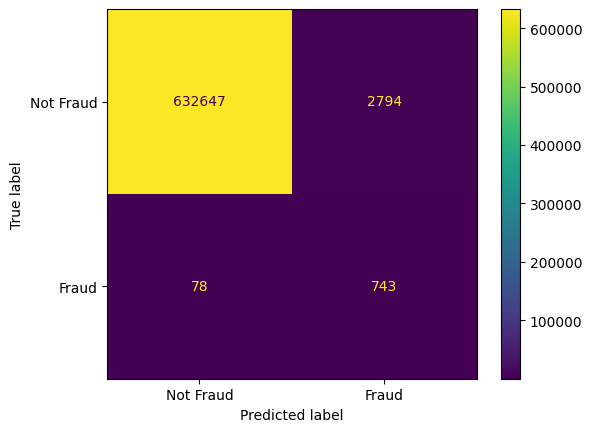

In [67]:
from sklearn.neighbors import KNeighborsClassifier
KNCmodel = KNeighborsClassifier()
KNCmodel.fit(X_Train_smote,Y_Train_smote)
# accuracy on test data
print('KNeighbours Classifier Model:')
X_test_prediction = np.array(KNCmodel.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

XG Boost with SMOTE

XGBoost Model:
[[624250  11191]
 [     2    819]]
Accuracy score on Test Data : 0.9824081903366852%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.98      0.99    635441
    Fraud [1]       0.07      1.00      0.13       821

     accuracy                           0.98    636262
    macro avg       0.53      0.99      0.56    636262
 weighted avg       1.00      0.98      0.99    636262



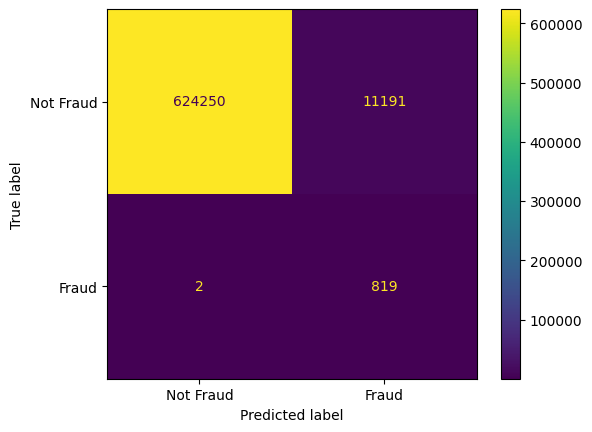

In [68]:
import xgboost as xgb
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
xgbr.fit(X_Train_smote, Y_Train_smote)
print('XGBoost Model:')
X_test_prediction = np.array(xgbr.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Random Forest Classifier with SMOTE

Random Forest Model:
[[635009    432]
 [    31    790]]
Accuracy score on Test Data : 0.9992723123493152%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.65      0.96      0.77       821

     accuracy                           1.00    636262
    macro avg       0.82      0.98      0.89    636262
 weighted avg       1.00      1.00      1.00    636262



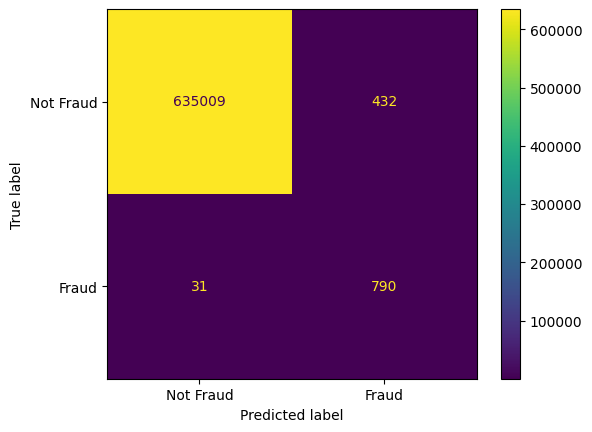

In [69]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_Train_smote, Y_Train_smote)
print('Random Forest Model:')
X_test_prediction = np.array(rfc.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))
# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = ["Not Fraud", "Fraud"])
cm_display.plot()
plt.show()

Decision Tree Classifier with SMOTE

In [70]:
from sklearn.tree import DecisionTreeClassifier
dt_c=DecisionTreeClassifier(random_state=42)
dt_c.fit(X_Train_smote, Y_Train_smote)
print('Decision Tree Classifier Model:')
X_test_prediction = np.array(dt_c.predict(X_Test))
Y_T = np.array(Y_Test)
conf_matrix = confusion_matrix(Y_T,X_test_prediction)
print(conf_matrix)
accuracy = accuracy_score(Y_T,X_test_prediction)
print(f"Accuracy score on Test Data : {accuracy}%")
print(classification_report(Y_T,X_test_prediction, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']))

Decision Tree Classifier Model:
[[635153    288]
 [    22    799]]
Accuracy score on Test Data : 0.9995127793267553%
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00    635441
    Fraud [1]       0.74      0.97      0.84       821

     accuracy                           1.00    636262
    macro avg       0.87      0.99      0.92    636262
 weighted avg       1.00      1.00      1.00    636262



Hence, best model wrt F1 score, Precision, Recall & Accuracy -> <br>
Decision Tree Classifier without balancing :-<br>
F1 score - 0.91<br>
Accuracy - 1.00<br>
Random Forest Classifier also performed well overall with F1 score of 0.87